In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Polygon
import os
import wget

polygons

In [ ]:
#wget.download("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip")

In [156]:
gdf = gpd.read_file('D:/opioids/cb_2018_us_county_500k')
gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


Pills

In [37]:
df1 = pd.read_csv('D:/opioids/hydrocodone_agg.csv',index_col=0)
df1 = df1.rename(columns={'sum(DOSAGE_UNIT)':'hydrocodone'})

In [38]:
df2 = pd.read_csv('D:/opioids/oxycodone_agg.csv',index_col=0)
df2 = df2.rename(columns={'sum(DOSAGE_UNIT)':'oxycodone'})

In [109]:
df = df1.merge(df2, how='outer', on = ['BUYER_STATE','BUYER_COUNTY','year','month'])
df['hydrocodone'] = df['hydrocodone'].fillna(0)
df['oxycodone'] = df['oxycodone'].fillna(0)
df['total'] = df['hydrocodone'] + df['oxycodone']
df = df[['BUYER_STATE','BUYER_COUNTY','year','month','total']]

In [40]:
df_remaining = pd.read_csv('D:/opioids/county_monthly14.csv')
df_remaining = df_remaining[['BUYER_STATE','BUYER_COUNTY','year','month','DOSAGE_UNIT']]
df_remaining = df_remaining[df_remaining['year']>2012]
df_remaining = df_remaining.rename(columns={'DOSAGE_UNIT':'total'})

In [110]:
df = pd.concat([df,df_remaining])

In [111]:
df = df[df['BUYER_STATE']!='PR'] #no Puerto Rico
df = df[df['BUYER_STATE']!='VI'] #no Virgin Islands
df = df[df['BUYER_STATE']!='GU'] #no Guam
df = df[df['BUYER_STATE']!='MP'] #no Mariana Islands
df = df[df['BUYER_STATE']!='AE'] #no Armed Forces Europe
df = df[df['BUYER_STATE']!='PW'] #no Palau
df = df[~pd.isnull(df['BUYER_COUNTY'])]

In [68]:
df.head()

,BUYER_STATE,BUYER_COUNTY,year,month,total
0,NY,JEFFERSON,2011,11,302850.0
1,NY,ONEIDA,2010,10,727590.0
2,NY,TOMPKINS,2010,9,238100.0
3,NH,SULLIVAN,2008,9,85500.0
4,VT,ORLEANS,2006,3,56200.0


GEO IDs

In [77]:
countyids = pd.read_csv('D:/opioids/county_fips.csv')
countyids['countyfips'] = countyids['countyfips'].astype(str).str.zfill(5)
countyids.head()

,BUYER_COUNTY,BUYER_STATE,countyfips
0,AUTAUGA,AL,01001
1,BALDWIN,AL,01003
2,BARBOUR,AL,01005
3,BIBB,AL,01007
4,BLOUNT,AL,01009


In [112]:
df = df.merge(countyids, how='outer', on = ['BUYER_STATE','BUYER_COUNTY'])
df[(df['BUYER_STATE'] == 'AR') & (df['BUYER_COUNTY'] == 'MONTGOMERY')] = df[(df['BUYER_STATE'] == 'AR') & (df['BUYER_COUNTY'] == 'MONTGOMERY')].assign(countyfips = '05097')
df = df.rename(columns={'countyfips':'GEOID'})
df.head()

,BUYER_STATE,BUYER_COUNTY,year,month,total,GEOID
0,NY,JEFFERSON,2011.0,11.0,302850.0,36045
1,NY,JEFFERSON,2010.0,12.0,307260.0,36045
2,NY,JEFFERSON,2006.0,9.0,171100.0,36045
3,NY,JEFFERSON,2006.0,3.0,171400.0,36045
4,NY,JEFFERSON,2010.0,10.0,270930.0,36045


Population

In [103]:
dfpop = pd.read_csv('D:/opioids/population0612.csv',index_col=0)
dfpop['state_fip'] = dfpop['state_fip'].astype(str).str.zfill(2)
dfpop['county_fip'] = dfpop['county_fip'].astype(str).str.zfill(3)
dfpop['GEOID'] = dfpop['state_fip'] + dfpop['county_fip'] 
dfpop = dfpop.rename(columns={'state':'BUYER_STATE'})
dfpop = dfpop[['year','BUYER_STATE','GEOID','population']]
dfpop.head()

,year,BUYER_STATE,GEOID,population
0,2006,CT,09009,850207
1,2006,GA,13005,10682
2,2006,LA,22023,7719
3,2006,ME,23015,34904
4,2006,MI,26109,24472


Pills per capita

In [126]:
df_pills = df.merge(dfpop, how='outer', on = ['BUYER_STATE','year','GEOID'])
df_pills[pd.isnull(df_pills['total'])] = df_pills[pd.isnull(df_pills['total'])].assign(total = 0.0)
df_pills['pills_pc'] = df_pills['total']/df_pills['population']
df_pills = df_pills[['year','month','BUYER_STATE','BUYER_COUNTY','GEOID','pills_pc']]
df_pills.head()

,year,month,BUYER_STATE,BUYER_COUNTY,GEOID,pills_pc
0,2011.0,11.0,NY,JEFFERSON,36045,2.570686
1,2011.0,4.0,NY,JEFFERSON,36045,2.445144
2,2011.0,2.0,NY,JEFFERSON,36045,2.367052
3,2011.0,10.0,NY,JEFFERSON,36045,2.606932
4,2011.0,1.0,NY,JEFFERSON,36045,2.582995


In [131]:
df_pills[pd.isnull(df_pills['year'])]

,year,month,BUYER_STATE,BUYER_COUNTY,GEOID,pills_pc
322384,NaN,NaN,AK,BRISTOL BAY,02060,NaN
322385,NaN,NaN,AK,DILLINGHAM,02070,NaN
322386,NaN,NaN,AK,LAKE AND PENINSULA,02164,NaN
322387,NaN,NaN,AK,SKAGWAY HOONAH ANGOON,02232,NaN
322388,NaN,NaN,AK,WADE HAMPTON,02270,NaN
...,...,...,...,...,...,...
322483,NaN,NaN,VA,MANASSAS PARK CITY,51685,NaN
322484,NaN,NaN,VA,WILLIAMSBURG CITY,51830,NaN
322485,NaN,NaN,WI,FLORENCE,55037,NaN
322486,NaN,NaN,WI,MENOMINEE,55078,NaN


PDMPs

In [136]:
pdmp = pd.read_stata('D:/opioids/opioids/PDMP.dta')
pdmp = pdmp[['statefip','statecode','mopdmp_year','mopdmp_month']]
pdmp = pdmp.rename(columns={'statecode':'BUYER_STATE','mopdmp_year':'year','mopdmp_month':'month'})
pdmp['statefip'] = pdmp['statefip'].astype(str).str.zfill(2)
pdmp.head()

,statefip,BUYER_STATE,year,month
0,2.0,AK,2012.0,1.0
1,1.0,AL,2006.0,4.0
2,5.0,AR,2013.0,5.0
3,4.0,AZ,2008.0,12.0
4,6.0,CA,2009.0,9.0


In [150]:
df_pills['treatment'] = 0

In [151]:
for i in np.unique(pdmp['BUYER_STATE']):
    p_year = np.array(pdmp[pdmp['BUYER_STATE']==i])[0,2]
    p_month = np.array(pdmp[pdmp['BUYER_STATE']==i])[0,3]
    if p_year < 2006:
        df_pills[df_pills['BUYER_STATE'] == i] = df_pills[df_pills['BUYER_STATE'] == i].assign(treatment = 1.0)
    elif 2005 < p_year < 2015:
        for j in range(2006,2015):
            if p_year < j:
                df_pills[(df_pills['BUYER_STATE'] == i)&(df_pills['year'] == j)] = df_pills[(df_pills['BUYER_STATE'] == i)&(df_pills['year'] == j)].assign(treatment = 1.0)
            elif p_year == j:
                for k in range(1,13):
                    if p_month <= k:
                        df_pills[(df_pills['BUYER_STATE'] == i)&(df_pills['year'] == j)&(df_pills['month'] == k)] = df_pills[(df_pills['BUYER_STATE'] == i)&(df_pills['year'] == j)&(df_pills['month'] == k)].assign(treatment = 1.0)

Polygons

In [159]:
gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


In [161]:
df_pills.head()

,year,month,BUYER_STATE,BUYER_COUNTY,GEOID,pills_pc,treatment
0,2011.0,11.0,NY,JEFFERSON,36045,2.570686,0
1,2011.0,4.0,NY,JEFFERSON,36045,2.445144,0
2,2011.0,2.0,NY,JEFFERSON,36045,2.367052,0
3,2011.0,10.0,NY,JEFFERSON,36045,2.606932,0
4,2011.0,1.0,NY,JEFFERSON,36045,2.582995,0


In [168]:
df_final = df_pills.merge(gdf,how='outer',on='GEOID')
df_final = gpd.GeoDataFrame(df_final)
df_final.head()

,year,month,BUYER_STATE,BUYER_COUNTY,GEOID,pills_pc,treatment,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry
0,2011.0,11.0,NY,JEFFERSON,36045,2.570686,0.0,36,045,00974121,0500000US36045,Jefferson,06,3.285906e+09,1.524629e+09,"MULTIPOLYGON (((-76.14753 43.94248, -76.14566 ..."
1,2011.0,4.0,NY,JEFFERSON,36045,2.445144,0.0,36,045,00974121,0500000US36045,Jefferson,06,3.285906e+09,1.524629e+09,"MULTIPOLYGON (((-76.14753 43.94248, -76.14566 ..."
2,2011.0,2.0,NY,JEFFERSON,36045,2.367052,0.0,36,045,00974121,0500000US36045,Jefferson,06,3.285906e+09,1.524629e+09,"MULTIPOLYGON (((-76.14753 43.94248, -76.14566 ..."
3,2011.0,10.0,NY,JEFFERSON,36045,2.606932,0.0,36,045,00974121,0500000US36045,Jefferson,06,3.285906e+09,1.524629e+09,"MULTIPOLYGON (((-76.14753 43.94248, -76.14566 ..."
4,2011.0,1.0,NY,JEFFERSON,36045,2.582995,0.0,36,045,00974121,0500000US36045,Jefferson,06,3.285906e+09,1.524629e+09,"MULTIPOLYGON (((-76.14753 43.94248, -76.14566 ..."


In [171]:
df_final[pd.isnull(df_final['GEOID'])]

,year,month,BUYER_STATE,BUYER_COUNTY,GEOID,pills_pc,treatment,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry


PLOT

In [200]:
year,month = 2007, 1
df_plot = df_final[(df_final['year'] == year) & (df_final['month'] == month)]
remaining = df_final[df_final['GEOID'].isin(set(df_final.GEOID) - set(df_plot.GEOID))]
remaining = remaining[~remaining.duplicated('GEOID')]
df_plot = pd.concat([df_plot,remaining])

,year,month,BUYER_STATE,BUYER_COUNTY,GEOID,pills_pc,treatment,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry
142135,2012.0,10.0,TN,VAN BUREN,47175,3.467799,1.0,47,175,01648584,0500000US47175,Van Buren,06,7.081424e+08,2893456.0,"POLYGON ((-85.61456 35.76159, -85.61190 35.760..."
266580,2006.0,5.0,GA,TALBOT,13263,0.316137,0.0,13,263,00326757,0500000US13263,Talbot,06,1.013663e+09,8766848.0,"POLYGON ((-84.70320 32.70072, -84.69965 32.700..."
279455,2012.0,4.0,NV,PERSHING,32027,1.510664,1.0,32,027,00858646,0500000US32027,Pershing,06,1.563469e+10,79934815.0,"POLYGON ((-119.33870 40.15760, -119.33821 40.3..."
280577,2012.0,6.0,IL,HENDERSON,17071,0.993190,1.0,17,071,00424237,0500000US17071,Henderson,06,9.810590e+08,42557504.0,"POLYGON ((-91.18543 40.63807, -91.15914 40.651..."
299580,2010.0,11.0,CO,CUSTER,08027,0.023375,1.0,08,027,00198129,0500000US08027,Custer,06,1.913032e+09,3364150.0,"POLYGON ((-105.79690 38.26505, -105.76555 38.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323842,NaN,NaN,NaN,NaN,72075,NaN,NaN,72,075,01804518,0500000US72075,Juana Díaz,13,1.561171e+08,121328720.0,"POLYGON ((-66.56536 18.12972, -66.56394 18.130..."
323843,NaN,NaN,NaN,NaN,72071,NaN,NaN,72,071,01804516,0500000US72071,Isabela,13,1.432558e+08,94636933.0,"POLYGON ((-67.10338 18.51384, -67.10025 18.515..."
323844,NaN,NaN,NaN,NaN,72085,NaN,NaN,72,085,01804523,0500000US72085,Las Piedras,13,8.774836e+07,32509.0,"POLYGON ((-65.92834 18.14284, -65.92608 18.144..."
323845,NaN,NaN,NaN,NaN,72117,NaN,NaN,72,117,01804539,0500000US72117,Rincón,13,3.700546e+07,103924383.0,"POLYGON ((-67.27067 18.36619, -67.26118 18.370..."


c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\guill\AppData\Local\Temp\ipykernel_6412\4223173049.py:52: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed

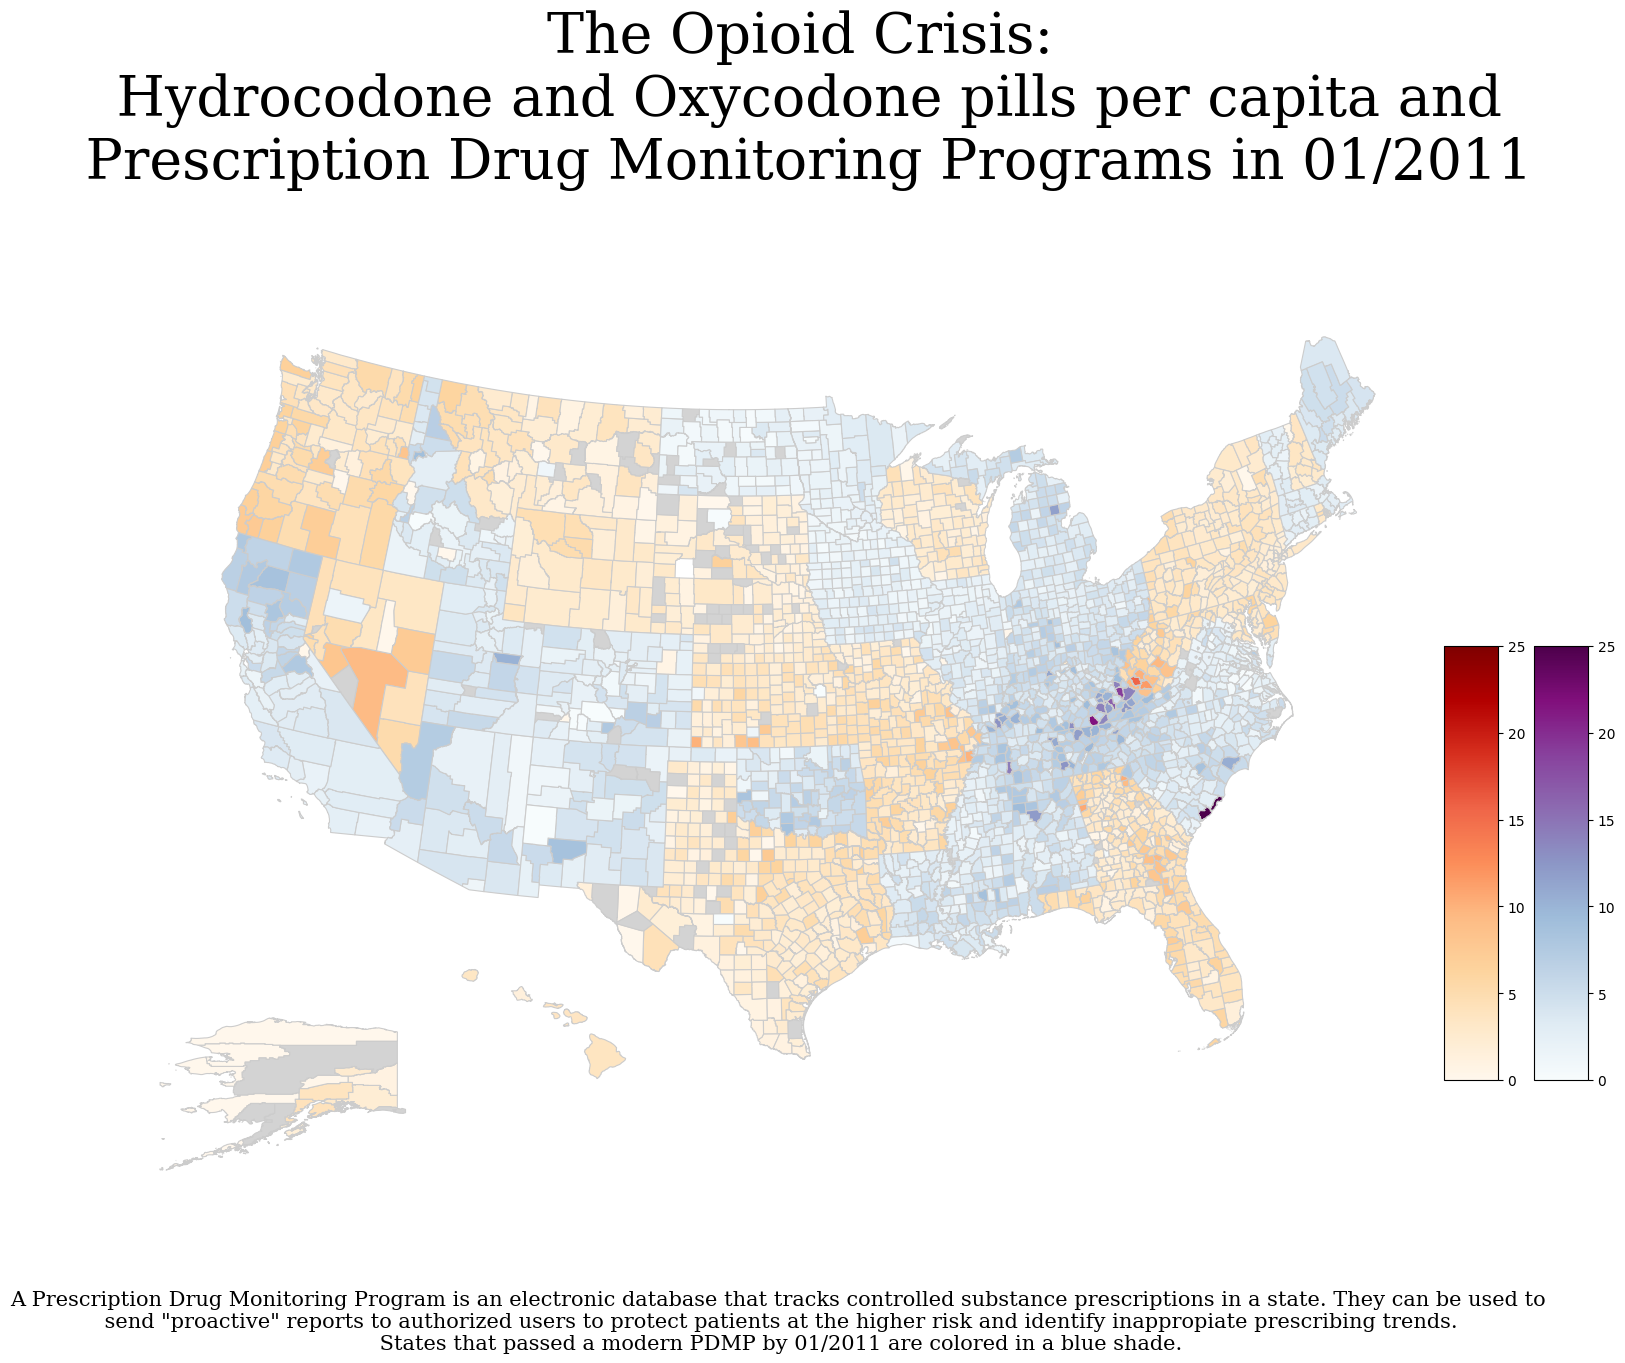

In [222]:

variable = 'pills_pc'

year,month = 2011, 1
vmin, vmax = 0, 25 

colormap_reg, colormap_pdmp = 'OrRd', 'BuPu'

df_plot = df_final[(df_final['year'] == year) & (df_final['month'] == month)]

remaining = df_final[df_final['GEOID'].isin(set(df_final.GEOID) - set(df_plot.GEOID))]
remaining = remaining[~remaining.duplicated('GEOID')]
df_plot = pd.concat([df_plot,remaining])

fig, ax = plt.subplots(1, figsize=(18, 14))
ax.set(xlim=(-2.5e6, 3e6), ylim=(-2.5e6, 1.25e6))  
ax.axis('off')

hfont = {'fontname':'serif'}


ax.set_title(f'The Opioid Crisis:\n Hydrocodone and Oxycodone pills per capita and\n Prescription Drug Monitoring Programs in {str(month).zfill(2)}/{year}', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

cbax1 = fig.add_axes([0.87, 0.21, 0.03, 0.31]) 
sm1 = plt.cm.ScalarMappable(cmap=colormap_reg,norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm1._A = []
fig.colorbar(sm1, cax=cbax1)

cbax2 = fig.add_axes([0.92, 0.21, 0.03, 0.31]) 
sm2 = plt.cm.ScalarMappable(cmap=colormap_pdmp,norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm2._A = []
fig.colorbar(sm2, cax=cbax2)


df_ante = df_plot[(~df_plot['BUYER_STATE'].isin(['AK','HI'])) & (df_plot['treatment'] == 0)]
visframe_ante = df_ante.to_crs({'init':'epsg:2163'})
visframe_ante.plot(variable,linewidth=0.8,ax=ax,vmin=vmin,vmax=vmax,edgecolor='0.8',aspect=1,missing_kwds= dict(color = "lightgrey"),cmap = colormap_reg)

df_post = df_plot[(~df_plot['BUYER_STATE'].isin(['AK','HI'])) & (df_plot['treatment'] == 1)]
visframe_post = df_post.to_crs({'init':'epsg:2163'})
visframe_post.plot(variable,linewidth=0.8,ax=ax,vmin=vmin,vmax=vmax,edgecolor='0.8',aspect=1,missing_kwds= dict(color = "lightgrey"),cmap = colormap_pdmp)

left_al, bottom_al, width_al, height_al = [0.15, 0.0, 0.15, 0.4] 
ax2 = fig.add_axes([left_al, bottom_al, width_al, height_al])
ax2.axis('off')

alaska_ante = df_plot[(df_plot['BUYER_STATE'] == 'AK') & (df_plot['treatment'] == 0)]
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_ante.clip(polygon).plot(variable,linewidth=0.8,ax=ax2,vmin=vmin,vmax=vmax, edgecolor='0.8',aspect=1,missing_kwds= dict(color = "lightgrey"),cmap = colormap_reg)

alaska_post = df_plot[(df_plot['BUYER_STATE'] == 'AK') & (df_plot['treatment'] == 1)]
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_post.clip(polygon).plot(variable,linewidth=0.8,ax=ax2,vmin=vmin,vmax=vmax, edgecolor='0.8',aspect=1,missing_kwds= dict(color = "lightgrey"),cmap = colormap_pdmp)


left_ha, bottom_ha, width_ha, height_ha = [0.32, 0.1, 0.1, 0.3]
ax3 = fig.add_axes([left_ha, bottom_ha, width_ha, height_ha])  
ax3.axis('off')

hawaii_ante = df_plot[(df_plot['BUYER_STATE'] == 'HI') & (df_plot['treatment'] == 0)]
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_ante.clip(hipolygon).plot(variable,linewidth=0.8,ax=ax3,vmin=vmin,vmax=vmax, edgecolor='0.8',aspect=1,missing_kwds= dict(color = "lightgrey"),cmap = colormap_reg)

hawaii_post = df_plot[(df_plot['BUYER_STATE'] == 'HI') & (df_plot['treatment'] == 1)]
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_post.clip(hipolygon).plot(variable,linewidth=0.8,ax=ax3,vmin=vmin,vmax=vmax, edgecolor='0.8',aspect=1,missing_kwds= dict(color = "lightgrey"),cmap = colormap_pdmp)


text = fig.text(0.50, 0.02,f'A Prescription Drug Monitoring Program is an electronic database that tracks controlled substance prescriptions in a state. They can be used to\n send "proactive" reports to authorized users to protect patients at the higher risk and identify inappropiate prescribing trends.\n States that passed a modern PDMP by {str(month).zfill(2)}/{year} are colored in a blue shade.', horizontalalignment='center',wrap=True,**hfont, fontdict={'fontsize': '15', 'fontweight' : '1'}) 